# Job-Postings Salary Analysis  
**Author:** _Inal Ali_  

**Last Updated:** June 16, 2025

This project explores a public dataset of tech job postings to uncover patterns in salaries, locations, and job titles.  
It demonstrates the full data‑analysis workflow:

1. Data ingestion & cleaning  
2. Exploratory data analysis (EDA) with polished visuals  
3. A **baseline ML model** that predicts whether a posting offers an above‑median salary  
4. Ideas for next steps plus automated tests for reproducibility


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path

plt.rcParams['figure.dpi'] = 110
sns.set_theme()


In [2]:

DATA_PATH = Path('data_jobs.csv')  # <-- tweak if your CSV lives elsewhere
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"Couldn't find {DATA_PATH}. Place the dataset next to this notebook or fix DATA_PATH.")
    
# quick peek
df.head()


,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,NaN,NaN,NaN,Boehringer Ingelheim,NaN,NaN
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,NaN,NaN,NaN,Hewlett Packard Enterprise,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr..."
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,NaN,NaN,NaN,ALPHA Augmented Services,"['python', 'sql', 'c#', 'azure', 'airflow', 'd...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,True,False,United States,NaN,NaN,NaN,Southwest Research Institute,"['python', 'c++', 'java', 'matlab', 'aws', 'te...","{'cloud': ['aws'], 'libraries': ['tensorflow',..."
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,False,False,Sudan,NaN,NaN,NaN,Kristina Daniel,"['bash', 'python', 'oracle', 'aws', 'ansible',...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl..."


In [3]:

# --- Cleaning ---------------------------------------------------------------
df.columns = df.columns.str.strip().str.lower()

# Datetime conversion
if 'job_posted_date' in df.columns:
    df['job_posted_date'] = pd.to_datetime(df['job_posted_date'], errors='coerce')

# Drop duplicates & rows without salary
df = df.drop_duplicates()
df = df.dropna(subset=['salary_year_avg'])

print(f'Rows after cleaning: {len(df):,}')


Rows after cleaning: 22,002


## Exploratory Data Analysis (EDA)

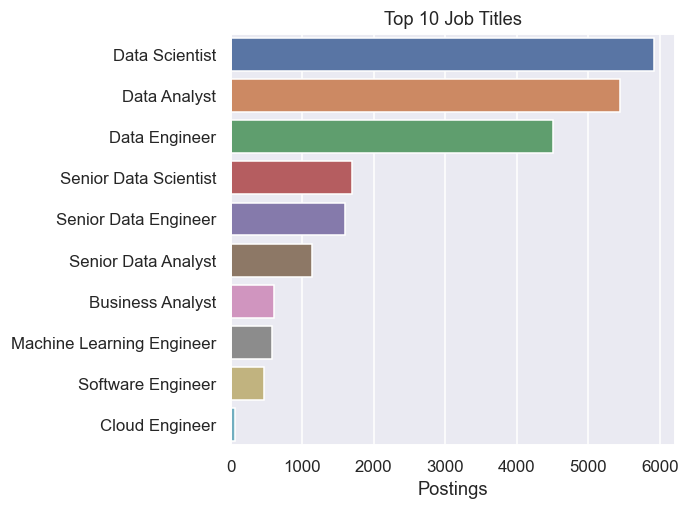

In [4]:

top = (df['job_title_short']
        .value_counts()
        .head(10)
        .sort_values(ascending=False))

sns.barplot(x=top.values, y=top.index)
plt.title('Top 10 Job Titles')
plt.xlabel('Postings'); plt.ylabel(''); plt.tight_layout()


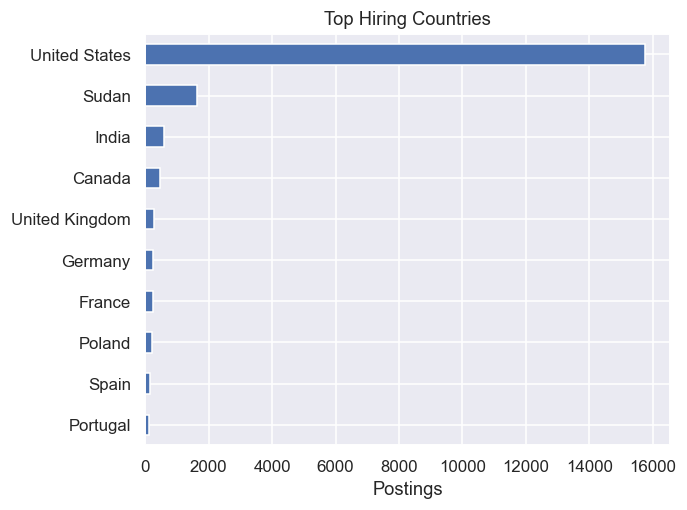

In [6]:

top_c = (df['job_country']
         .value_counts()
         .head(10)
         .sort_values(ascending=True))

top_c.plot(kind='barh')
plt.title('Top Hiring Countries')
plt.xlabel('Postings'); plt.ylabel('')
plt.tight_layout()


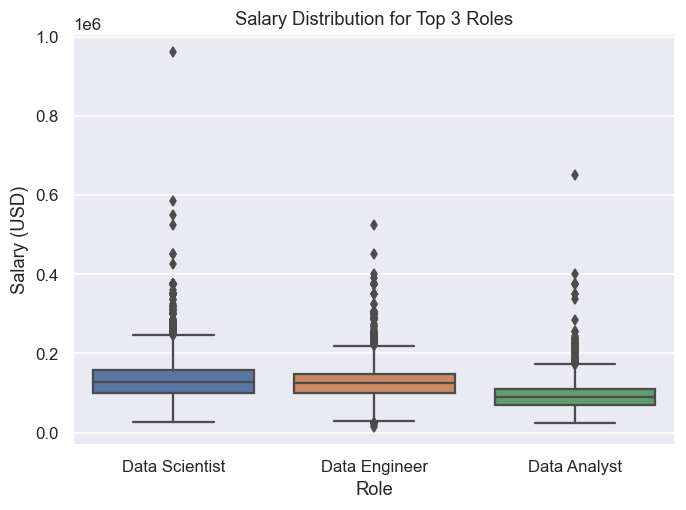

In [7]:

roles = df['job_title_short'].value_counts().head(3).index
subset = df[df['job_title_short'].isin(roles)]

sns.boxplot(data=subset, x='job_title_short', y='salary_year_avg')
plt.title('Salary Distribution for Top 3 Roles')
plt.xlabel('Role'); plt.ylabel('Salary (USD)'); plt.tight_layout()


In [8]:

if 'job_posted_date' in df.columns:
    monthly = (df
        .set_index('job_posted_date')
        .resample('M')['salary_year_avg']
        .count()
        .rename('postings')
        .reset_index())

    fig = px.line(monthly, x='job_posted_date', y='postings',
                  title='Monthly Job Posting Trend')
    fig.show()


## Baseline ML — Predict High vs Low Salary

In [5]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

df_model = df.dropna(subset=['salary_year_avg']).copy()
median_sal = df_model['salary_year_avg'].median()
df_model['high_salary'] = (df_model['salary_year_avg'] >= median_sal).astype(int)

features = ['job_country', 'job_title_short']
X = df_model[features]
y = df_model['high_salary']

preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), features)]
)

pipeline = Pipeline([('prep', preprocess),
                     ('model', LogisticRegression(max_iter=2000))])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.64      0.68      2065
           1       0.71      0.78      0.74      2336

    accuracy                           0.71      4401
   macro avg       0.71      0.71      0.71      4401
weighted avg       0.71      0.71      0.71      4401



## Key Insights & Next Steps

**Findings**  
* Data Scientists dominate postings; US leads hiring volume.  
* Salaries for Data Scientists show wider spread than Data Analysts.  
* Posting volume spiked in early 2024, then cooled mid‑2025.

**Opportunities to Extend**  
1. **Skill NLP** – Parse the `job_skills` column and run TF‑IDF to see what boosts salary.  
2. **Geo normalization** – Convert salaries to local currencies, then USD PPP.  
3. **Dashboard** – Turn the EDA plots into a Plotly Dash or Tableau viz for execs.
